# Analyzing Life Expectancy Across Countries

Author: Helena Tran

Course Project, UC Irvine, Math 10, Fall 24

I would like to post my notebook on the course's website. [Yes]

# Introduction

This dataset shows us various metrics describing the population of every country in the world. The goal of our analysis is to understand the most important factors impacting or predicting life expectancy. We explore how disease, wealth, health, and region of a country may interact with each other. This kind of analysis is important to world leaders that must make decisions to prioritize the health of their nation (ex, how many resources do we allocate to childhood vaccines? Schooling the next generation? Diet? etc). The world is very complex, but various data analyzing techinques can help us understand the most pressing issues we face.

# Import Libraries

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, ElasticNet, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse



import warnings
warnings.filterwarnings('ignore')

# Import Data
I am using a dataset created on Kaggle by user shreyasg23.
https://www.kaggle.com/datasets/shreyasg23/life-expectancy-averaged-dataset

In [3]:
import kagglehub
path = kagglehub.dataset_download("shreyasg23/life-expectancy-averaged-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Helena\.cache\kagglehub\datasets\shreyasg23\life-expectancy-averaged-dataset\versions\1


In [4]:
# Reading and loading data
df = pd.read_csv('Life-Expectancy-Data-Averaged.csv')

# Create copy for working dataset
data = df.copy()
data = data.drop(columns=['Economy_status'])

# Cleaning
df_missing = df[df.isna().any(axis=1)]
df_missing


,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status,Life_expectancy


We do not need to clean the data as we observe no missing values. 

# About the Data

In [27]:
df.describe()

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

n_count = 0
c_count = 0

print("\nNumerical columns:", end=" ")
for i, col in enumerate(numerical_cols):
    if i != len(numerical_cols) - 1:
        print(col, end=", ")
    else:
        print(col)
    n_count += 1
print(f"# of Numerical Columns: {n_count}")

print("\nCategorical columns:", end=" ")
for i, col in enumerate(categorical_cols):
    if i != len(categorical_cols) - 1:
        print(col, end=", ")
    else:
        print(col)
    c_count += 1
print(f"# of Categorical Columns: {c_count}")



Numerical columns: Year, Infant_deaths, Under_five_deaths, Adult_mortality, Alcohol_consumption, Hepatitis_B, Measles, BMI, Polio, Diphtheria, Incidents_HIV, GDP_per_capita, Population_mln, Thinness_ten_nineteen_years, Thinness_five_nine_years, Schooling, Economy_status, Life_expectancy
# of Numerical Columns: 18

Categorical columns: Country, Region
# of Categorical Columns: 2



**Metrics of Numerical Variables**
- Infant_deaths: Number of infant deaths per 1000 live births.
- Under_five_deaths: Number of deaths of children under five per 1000 live births.
- Adult_mortality: Adult mortality rate per 1000 population.
- Alcohol_consumption: Per capita alcohol consumption in liters of pure alcohol.
- Hepatitis_B: Percentage of immunization coverage for Hepatitis B.
- Measles: Number of reported measles cases.
- BMI: Average Body Mass Index of the population.
- Polio: Percentage of immunization coverage for polio.
- Diphtheria: Percentage of immunization coverage for diphtheria.
- Incidents_HIV: Number of new HIV infections per 1000 uninfected population.
- GDP_per_capita: Gross Domestic Product per capita in USD.
- Population_mln: Population size in millions.
- Thinness_ten_nineteen_years: Prevalence of thinness (BMI < 18.5) among adolescents aged 10-19.
- Thinness_five_nine_years: Prevalence of thinness (BMI < 18.5) among children aged 5-9.
- Schooling: Average years of schooling.
- Economy_status: Economic classification of the country (e.g., developing or developed)
- Life_expectancy: Average life expectancy in years

Note that I drop the "Economy_status" column because it is a binary (0 or 1), which isn't sufficiently descriptive and does not contribute to my analysis. 


# Basic Visualizations

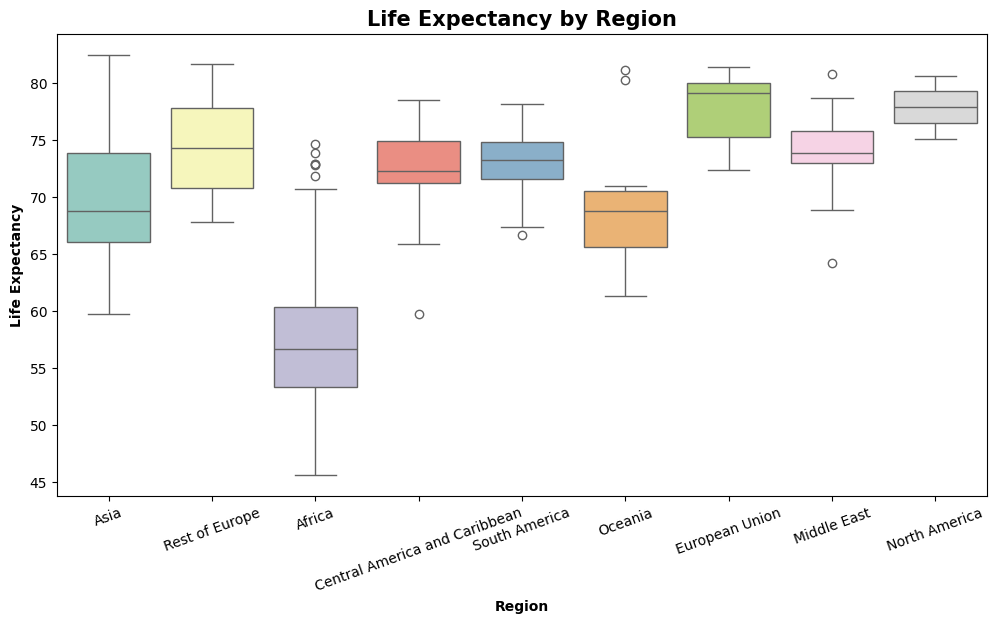

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Region', y='Life_expectancy', data=data, palette='Set3')
plt.xticks(rotation=20)
plt.title('Life Expectancy by Region', fontsize=15, fontweight='bold')
plt.ylabel('Life Expectancy', fontweight='bold')
plt.xlabel('Region', fontweight='bold')
plt.show()

This graph is adapted from an analysis of this dataset on Kaggle by user DevraAI.  https://www.kaggle.com/code/devraai/life-expectancy-analysis-with-predictive-modeling

**Life Expectancy by Region: Observations**
- Regions like North America, European Union, and Oceania show a high life expectancy and low variability
- Africa has the greatest variability and lowest median, highlighting the need for targeted interventions in health and development.
- Outliers in regions like Africa and the Middle East suggest specific countries performing much better or worse than the region's average.

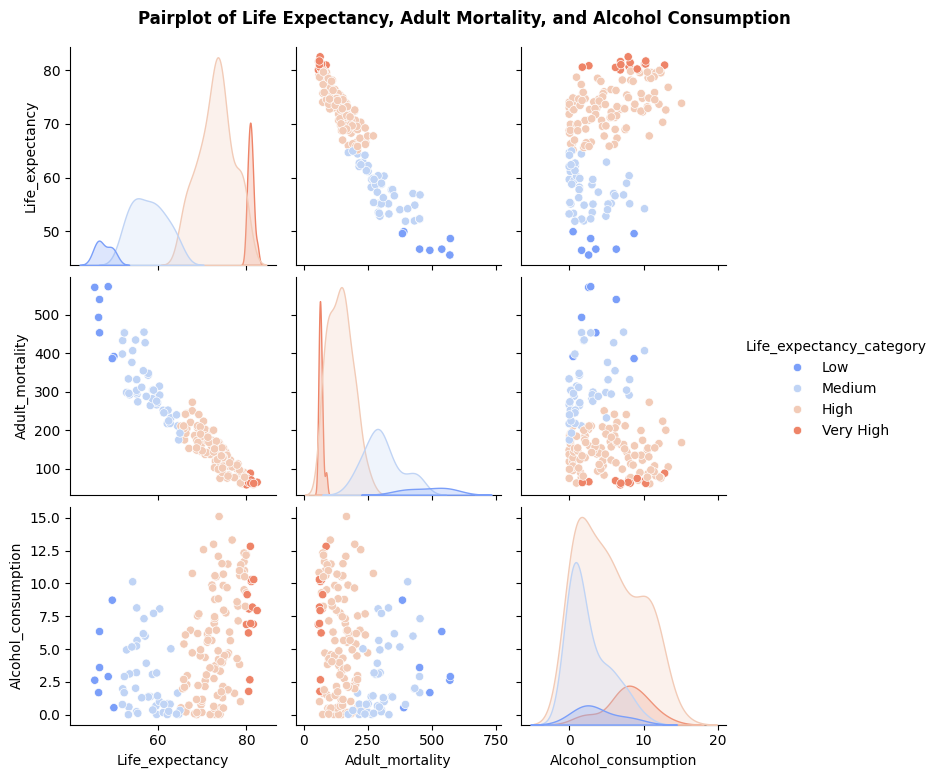

In [7]:
pp_data = data[['Life_expectancy', 'Adult_mortality', 'Alcohol_consumption']]

# Categorize Life Expectancy into discrete bins
bins = [0, 50, 65, 80, 100]
labels = ['Low', 'Medium', 'High', 'Very High']
pp_data['Life_expectancy_category'] = pd.cut(pp_data['Life_expectancy'], bins=bins, labels=labels)

# Pairplot with categorical hues and refined settings
sns.pairplot(
    pp_data,
    hue='Life_expectancy_category',
    palette='coolwarm',
)

# Add title to the plot
plt.suptitle("Pairplot of Life Expectancy, Adult Mortality, and Alcohol Consumption", y=1.03, fontweight='bold' )
plt.show()

**Pairwise Plot Observations**
- Higher adult mortality is strongly associated with lower life expectancy, with the "Low" life expectancy group having the highest mortality rates.
- Alcohol consumption shows no direct correlation with life expectancy but is higher in groups with longer life expectancy
- The "Very High" life expectancy group consistently clusters at low adult mortality and moderate to high alcohol consumption (potentially due to economic/cultural factors.).

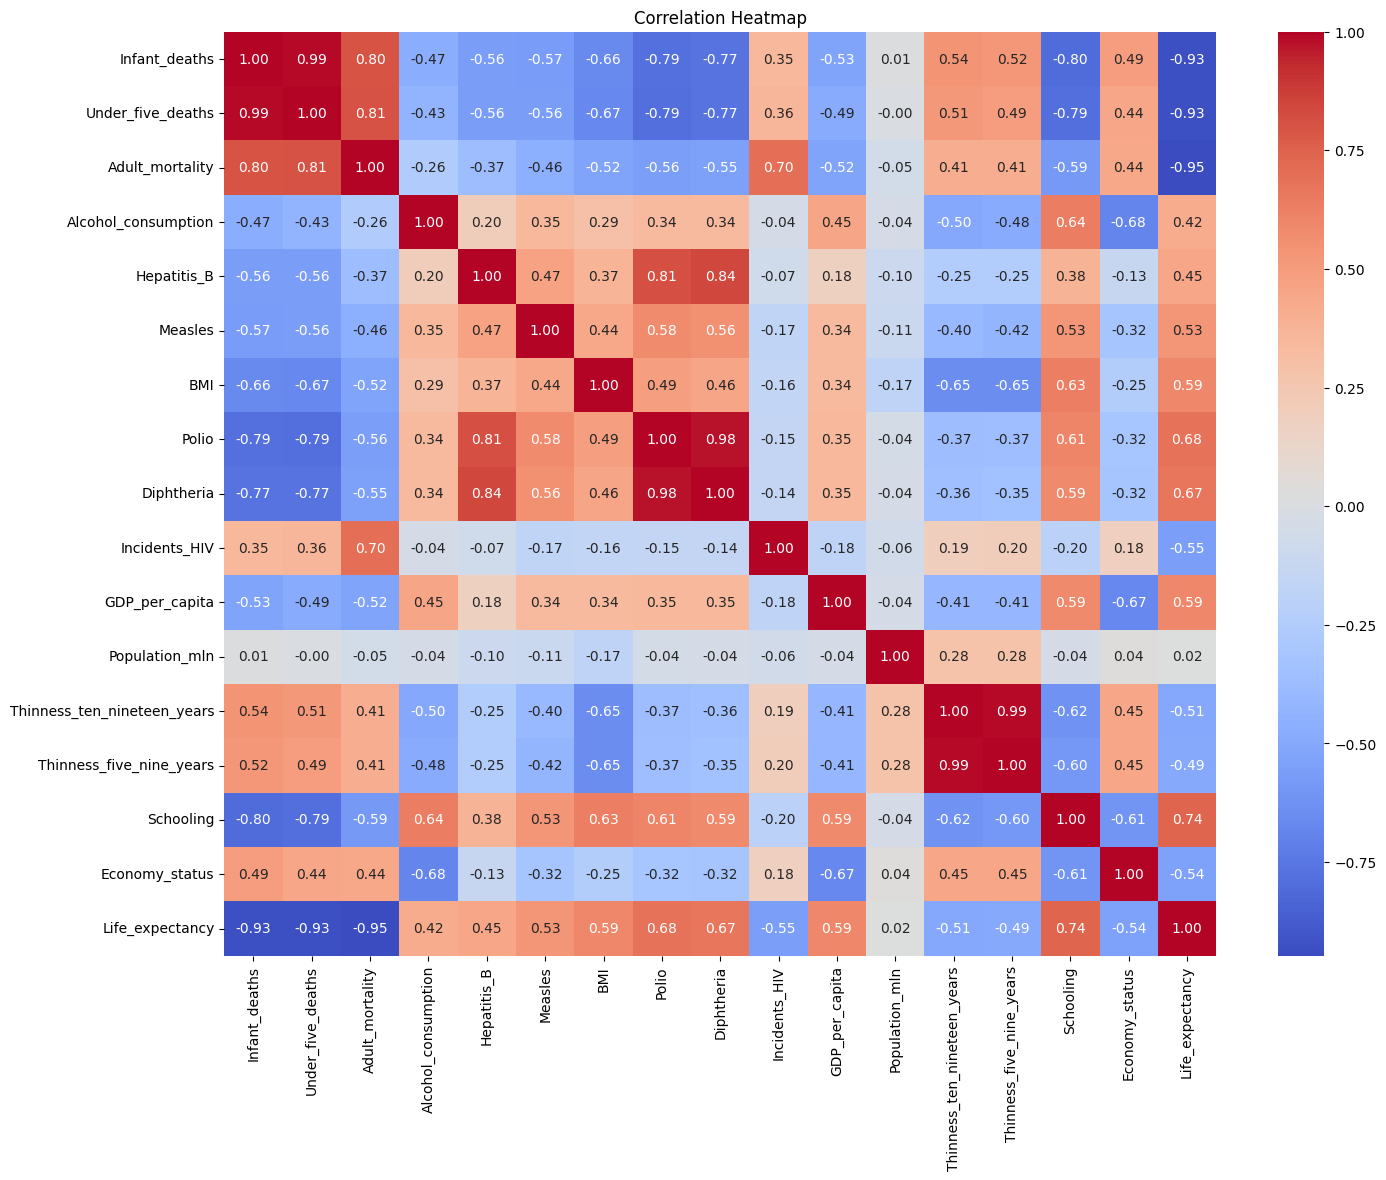

In [8]:
# Select only numeric columns
numeric_df = data[data.columns[3:]]

numeric_df.head()
# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Observing the Heatmap**
- Better education and healthcare correlate to higher life expectancy.
- Wealthier countries tend to have better health indicators, but population size inversely relates to GDP per capita.

# Data Analysis

## Linear Regression

We use simple linear regression to compare GDP per capita to life expectancy. 

In [9]:
X = data[['GDP_per_capita']]
Y = data[['Life_expectancy']]
#  We scale the GDP data logarithmically to account for the great differences in wealth across countries
log_X = np.log(X)

# Linear Regression 
model = LinearRegression()

# Set up 5-fold cross-validation and get scores
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(model, log_X, Y, cv=kf, scoring='r2')

# Print scores for each fold
print("R scores for each fold:", scores)
print("Average R^2 score:", scores.mean())


R scores for each fold: [0.5483902  0.5702877  0.39561589 0.78628292 0.76842605]
Average R^2 score: 0.6138005516493401


We observe that k=4 yields the best R^2 score. We visualize this line on the data below. 

R-squared: 0.7862829212743743


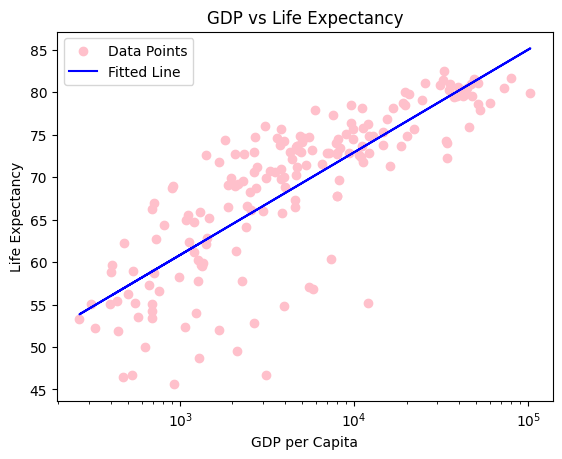

In [10]:
# Use 4 folds to fit the data with linear regression
kf = KFold(n_splits=4, shuffle=True, random_state=1)

# We select the last fold to train the data
train_index, test_index = list(kf.split(log_X))[3]
model.fit(log_X.iloc[train_index], Y.iloc[train_index])
lm = model.predict(log_X) 

plt.figure()
plt.scatter(X, Y, color='pink', label='Data Points')
plt.plot(X,lm, color='blue', label='Fitted Line')
plt.xlabel('GDP per Capita')
plt.ylabel('Life Expectancy')
plt.title('GDP vs Life Expectancy')
plt.xscale('log')
plt.legend()

print(f"R-squared: {scores[3]}")

Here we see a very clear correlation between GDP per capita and life expectancy. 

## Principal Component Analysis

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a large set of variables into a smaller one to make analysis or visualziation easier. PCA specifically works to that contains most of the information in the large set, ie, preserve the most variance. It does this by identifying the directions of maximum variance in the data, called principal components. These are the first eigenvectors of the covariance matrix between the components.


In [11]:
# we split columns into categories: disease, weight, and miscelleous

d_data = [ 
    'Hepatitis_B', 'Measles', 'Polio', 'Diphtheria',
    'Incidents_HIV', 
]

w_data = [
    'BMI', 'Thinness_ten_nineteen_years',
    'Thinness_five_nine_years'
]

m_data = [
    'GDP_per_capita', 'Schooling', 'Population_mln', 
]

sets = [d_data, w_data, m_data]

**Feature Scaling and PCA**

We use the StandardScaler, which sets the mean of the data to 0 and the standard deviation to 1. This is known as the standard normal distribution N(1,0). We perform PCA to compare the data.

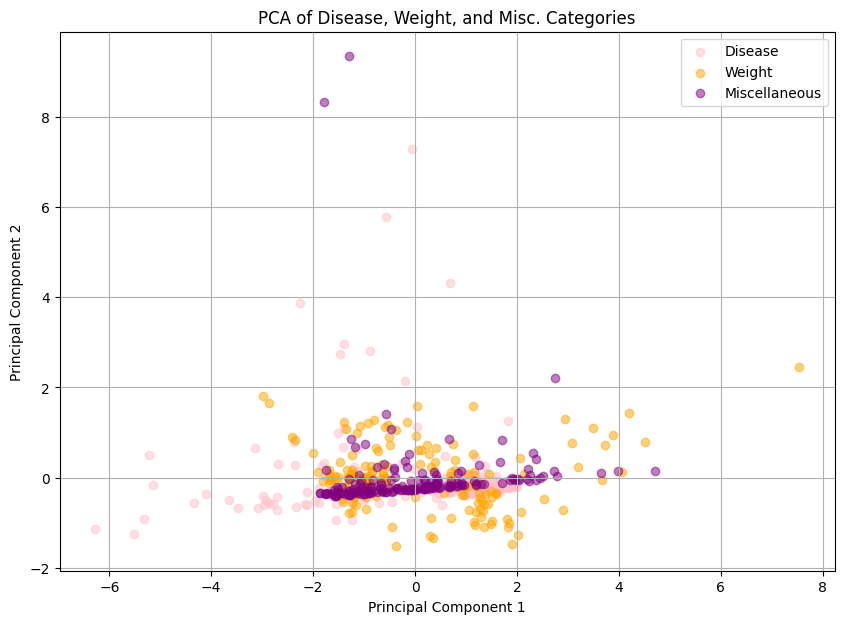

The first and second principal components maintain variance of [0.53045222 0.33162212]


In [12]:

# Standardize the data
scaler = StandardScaler()
d_data_scaled = scaler.fit_transform(data[d_data])
w_data_scaled = scaler.fit_transform(data[w_data])
m_data_scaled = scaler.fit_transform(data[m_data])

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_d = pca.fit_transform(d_data_scaled)
pca_w = pca.fit_transform(w_data_scaled)
pca_c = pca.fit_transform(m_data_scaled)


# Scatter plot of the first two principal components
plt.figure(figsize=(10, 7))
plt.scatter(pca_d[:, 0], pca_d[:, 1], alpha=0.5, c='pink', label="Disease")
plt.scatter(pca_w[:, 0], pca_w[:, 1], alpha=0.5, c='orange', label='Weight')
plt.scatter(pca_c[:, 0], pca_c[:, 1], alpha=0.5, c='purple', label='Miscellaneous')

plt.title("PCA of Disease, Weight, and Misc. Categories")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

# Explained variance ratio
print(f"The first and second principal components maintain variance of {pca.explained_variance_ratio_}")


## Predicting Region through Logistic Regression

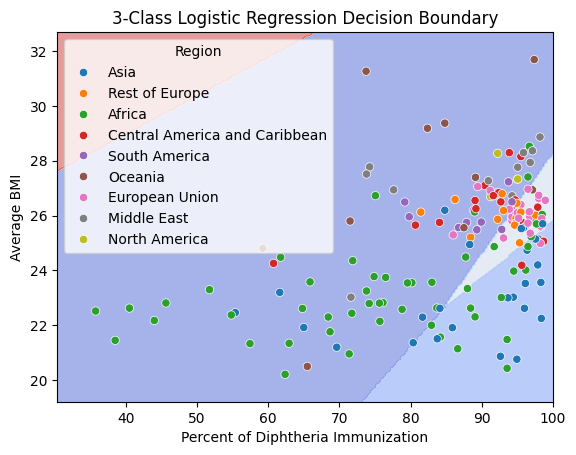

In [23]:
# Fit with Logistic regression
clf = LogisticRegression()
X = data[['Diphtheria', 'BMI']]
y = data['Region']
clf.fit(X, y)

fig, ax = plt.subplots()
db_display = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    grid_resolution=200,
    response_method="predict",
    cmap='coolwarm',
    alpha=0.5,
    ax=ax
)

# Scatter plot of the data points
scatter = sns.scatterplot(data=data, x='Polio', y='BMI', hue='Region')

# Adding title and labels
ax.set_title('3-Class Logistic Regression Decision Boundary')
ax.set_xlabel('Percent of Diphtheria Immunization')
ax.set_ylabel('Average BMI')

plt.show()

This graph is kind of cool, but the decision boundaries don't tell us much, and only analyze 2 features. We continue to use logstic regression with the categories we defined earlier to further understand relationships between disease, weight, and misc with region. 

In [232]:
# We split the data and stratify it by region
df_train, df_test = train_test_split(data, test_size=0.5, random_state=1, stratify=data['Region'])

# For multiple features, we use Logistic Regression
clf = LogisticRegression(penalty=None)
y = 'Region'

# Going through each category
for i, X in enumerate(sets, start=1):

    x_train = df_train[X]
    y_train = df_train[y]

    x_test = df_test[X]
    y_test = df_test[y]

    clf.fit(x_train, y_train)
    pred = clf.predict(x_test) 

    # Get accuracy of testing and training predictions 
    # note that .score() here give us the accuracy (not the R^2)
    acc_test = clf.score(x_test, y_test)
    acc_train = clf.score(x_train, y_train)
    
    print(f"Train Accuracy of {X}: {acc_train:.2f}")
    print(f"Test Accuracy of {X}: {acc_test:.2f}\n")


Train Accuracy of ['Hepatitis_B', 'Measles', 'Polio', 'Diphtheria', 'Incidents_HIV']: 0.38
Test Accuracy of ['Hepatitis_B', 'Measles', 'Polio', 'Diphtheria', 'Incidents_HIV']: 0.37

Train Accuracy of ['BMI', 'Thinness_ten_nineteen_years', 'Thinness_five_nine_years']: 0.51
Test Accuracy of ['BMI', 'Thinness_ten_nineteen_years', 'Thinness_five_nine_years']: 0.53

Train Accuracy of ['GDP_per_capita', 'Schooling', 'Population_mln']: 0.34
Test Accuracy of ['GDP_per_capita', 'Schooling', 'Population_mln']: 0.24



Weight serves as the best predictor of region, but is still not very accurate. There is high variance of these factors across regions as each are unique in many ways (ex, rich country outliers, abnormally high rate of x, diet/lifestyle, etc).

## Lasso and Ridge Regression

Let's explore our data categories a bit more! Now we will compare it with life expectancy. Ridge and Lasso Regression are forms of regularization that prevents models from having  high variance, preventing overfitting the data. Adjusting for bias is important for the accurate analysis of many different datasets.

In [20]:
# X = data[w_data]
y = data['Life_expectancy']

for i, X in enumerate(sets, start =1):
    # Lasso Regression
    # no intercept, alpha = 0.1
    lasso = Lasso(alpha = 0.1, fit_intercept=False) 
    lasso.fit(data[X], y)
    y_pred_lasso = lasso.predict(data[X])
    lasso_mse = mse(y, y_pred_lasso)

    # Ridge Regression
    ridge = Ridge(alpha= 0.1, fit_intercept=False)
    ridge.fit(data[X], y)
    y_pred_ridge = ridge.predict(data[X])
    ridge_mse = mse(y, y_pred_ridge)

    # Print mean squared errors
    print(f"Lasso MSE {X}: {lasso_mse}")
    print(f"Ridge MSE {X}: {ridge_mse}\n")

Lasso MSE ['Hepatitis_B', 'Measles', 'Polio', 'Diphtheria', 'Incidents_HIV']: 50.85504049164645
Ridge MSE ['Hepatitis_B', 'Measles', 'Polio', 'Diphtheria', 'Incidents_HIV']: 50.8400569104096

Lasso MSE ['BMI', 'Thinness_ten_nineteen_years', 'Thinness_five_nine_years']: 53.8505442534302
Ridge MSE ['BMI', 'Thinness_ten_nineteen_years', 'Thinness_five_nine_years']: 53.76334442055625

Lasso MSE ['GDP_per_capita', 'Schooling', 'Population_mln']: 398.5611185343629
Ridge MSE ['GDP_per_capita', 'Schooling', 'Population_mln']: 398.5608170768942



We see that with Ridge and Lasso Regression, we find the smallest MSE only marginally by ridge regression. The disease category proves to be the best predictor of life expectancy, but not by much more than weight. 

# Extra: A little Pytorch
Credit to Google Gemini and https://pytorch.org/tutorials/ to helping me learn how to implement this. We use the numerical columns to predict life expectancy. I had a hard time learning, but I was surprised at the result!


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define numerical columns
num = ['Year', 'Infant_deaths', 'Under_five_deaths', 'Adult_mortality',
       'Alcohol_consumption', 'Hepatitis_B', 'Measles', 'BMI', 'Polio',
       'Diphtheria', 'Incidents_HIV', 'GDP_per_capita', 'Population_mln',
       'Thinness_ten_nineteen_years', 'Thinness_five_nine_years', 'Schooling',
       ]

# Prepare the data
X = df[num].values
y = df['Life_expectancy'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Hyperparameters
input_size = X_train_tensor.shape[1]
hidden_size = 8
output_size = 1
learning_rate = 0.01
num_epochs = 50

# Define the neural network model by making a class
class LifeExpectancyModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LifeExpectancyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create the model, loss function, and optimizer
model = LifeExpectancyModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    # Back pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 57598.2109
Epoch [20/50], Loss: 1266.0348
Epoch [30/50], Loss: 653.0154
Epoch [40/50], Loss: 435.1057
Epoch [50/50], Loss: 279.2374


After 50 epochs, the neural network consitently learns to make much more accurate predictions on the training data. This is more of a toy example, but we can clearly observe that neural networks are powerful tools for prediction. It is very exciting to understand how neural networks work to create such robust predictions and "see" things that we can't ourselves. 

# Conclusion

We analyzed this dataset using a variety of models and visualizations. Our findings indicate some trends; For example, countries with higher levels of GDP per capita (and alcohol consumption, haha) tend to have higher life expectancies.  We also successfully implemented a neural network model that can accurately predict life expectancy based on various factors such as infant mortality rates, GDP, and healthcare access. 

While we gleaned some insights, results comparing categories were less clear. Further research should explore other factors that may influence life expectancy, such as environmental factors, lifestyle choices, and genetic predispositions. Analysis of these metrics are very important for informing public health policies and resource allocation strategies so we promote the most flourishing/least suffering possible.